## Overview:

In this tutorial I exhibit a prototypical workflow for approximating a target function by a feedforward ReLU network built with Pytorch. Along the way we point out possible modifications and provide suggestions that may help as you develop your own Pytorch workflow. The tutorial proceeds in five sections. 
   
1. Defining our target function
2. Data generation and preparation
2. Building network architectures with Pytorch
3. Training and evaluating a Pytorch model
4. Comments on hyper-parameter tuning
    
<b>Authorship and Citation: Students and researchers are free to borrow code from this jupyter notebook for their own academic and research purposes with citation.<b/>

In [1]:
# Import required packages

import numpy as np  # primary python numerical package
import torch  # primary package used to build neural network objects with Pytorch
import pickle # standard package used to store python objects  
import matplotlib.pyplot as plt # plotting and visualizing results
from sklearn.preprocessing import MinMaxScaler # data preparation
from tqdm import tqdm # visualizing neural network training progress
from torch.utils.data import Dataset, DataLoader # data preparation

## 1. Defining our target function:


Consider $f(x) = 2e^{-x}\cos^2(5x)$ for $x\in[0,2]$.

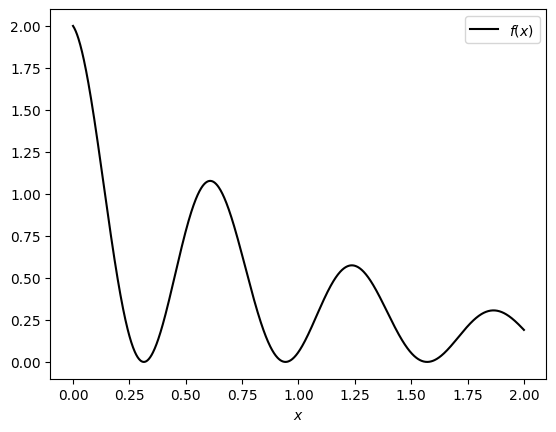

In [2]:
def f(x):
    
    return 2*np.exp(-x)*(np.cos(5*x))**2

x = np.linspace(0,2,1000) 

plt.plot(x,f(x), color = 'k', label = r'$f(x)$')
plt.xlabel(r'$x$')
plt.legend()
plt.show()
plt.close()

## 2. Data generation and preparation

`Pytorch` conducts all operations on `torch tensors`, which in this context can be thought of as multi-dimensional arrays that can also store gradient information. `Pytorch` integrates easily with `numpy`, and I prefer generating data as `numpy arrays` and then converting to `torch tensors` during training. You can alternatively work entirely with `torch tensors`, but I prefer the former for two reasons. 

1. Neural network approximation is often combined with other numerical tasks that are not easy to accomplish entirely using `torch tensors`; e.g., numerically solving systems of differential equations, visualizing the results of the approximation using a package like `matplotlib`. 

2. `numpy`, `scipy`, `scikitlearn`, and related packages are the canonical numerical analysis packages for `python`. They are extremely well documented and it is best to take advantage of this. 


<b> The three types of data:</b>

1. Training data
2. Validation data: used to tune hyperparameters and control adaptive aspects of training; e.g., learning rate and stopping criteria. For real world problems validation data comes out of your training data allotment and is therefore usually sparse.  
3. Testing data

<b>The importance of feature scaling:</b>


Stochastic gradient based training algorithms such as those generally used to train neural networks are generally very sensitive to feature scaling. This means that training inputs and outputs should be scaled to $[0,1]$ before training, and then scaled back to their native domain after evaluating the neural network on the test data. In this tutorial, we use the `scikitlearn` `MinMaxScaler`. This can also be done manually or via some other means. For example, another common practice is standardizing data with respect to a Gaussian distribution before training, which can be done with the `scikitlearn` `StandardScaler`.

<b> Data Formatting:</b>

For a data set with $N$ samples we create an array with $N$ rows, where each row contains a data sample (input and output); i.e. For data which has 1d input and output this will be an $Nx2$ matrix. 

$$\begin{pmatrix}
x^{(1)} & y^{(1)}\\
x^{(2)} & y^{(2)}\\
\vdots & \vdots \\
x^{(N)} & y^{(N)}
\end{pmatrix}$$


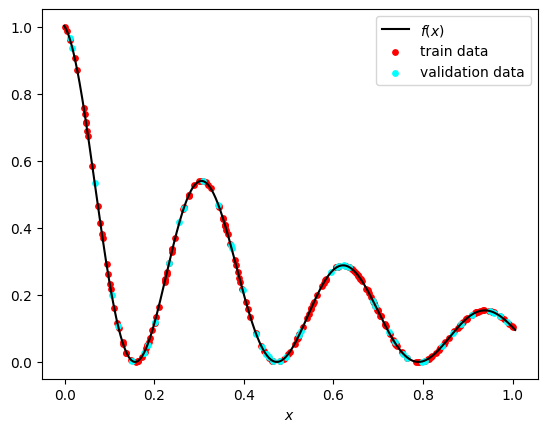

In [3]:
np.random.seed(101) # fix random seed for reproducibility

N_train = 200  # number of training samples
N_val = 50     # number of validation samples|
N_test = 1000  # number of testing samples

train_data = np.zeros((N_train, 2))    # allocate space for training data
val_data = np.zeros((N_val, 2))        # allocate space for validation data
test_data = np.zeros((N_test,2))       # allocate space for testing data

inputs = np.random.uniform(0,2, size = (N_train+N_val,1))  # generate N_train+N_val random uniform inputs in (0,2)

train_inputs = inputs[:N_train,:] 
val_inputs = inputs[N_train:,:] 
test_inputs = np.linspace(0,2,N_test).reshape((N_test,1))

train_outputs = f(train_inputs) 
val_outputs = f(val_inputs)
test_outputs = f(test_inputs)


input_scaler = MinMaxScaler() # instantiate scaler object for training, testing, and validation inputs

# scale input data to [0,1] wrt training data input distribution
train_inputs = input_scaler.fit_transform(train_inputs)
val_inputs = input_scaler.transform(val_inputs)
test_inputs = input_scaler.transform(test_inputs)


output_scaler = MinMaxScaler() # instantiate scaler object for training, testing, and validation outputs

# scale output data to [0,1] wrt training data output distribution
train_outputs = output_scaler.fit_transform(train_outputs)
val_outputs = output_scaler.transform(val_outputs)
test_outputs = output_scaler.transform(test_outputs)


# fill training, testing, and validation data arrays
train_data[:,:-1], train_data[:,-1:] = train_inputs, train_outputs
val_data[:,:-1], val_data[:,-1:] = val_inputs, val_outputs
test_data[:,:-1], test_data[:,-1:] = test_inputs, test_outputs


# visualize the scaled training, testing, and validation data
plt.plot(test_data[:,:-1],test_data[:,-1:], color = 'k', label = r'$f(x)$')
plt.scatter(train_data[:,:-1], train_data[:,-1:], color = 'red', s =15, label = 'train data')
plt.scatter(val_data[:,:-1], val_data[:,-1:], color = 'cyan', s = 15 , label = 'validation data')
plt.legend()
plt.xlabel(r'$x$')
plt.show()
plt.close()


Notice that the function has now been scaled such that both the domain and range are contained in $[0,1]$.

<b>Recommendations for Data Generation and Scaling </b>

1. Write a function that can generate training, testing, and validation data of prescribed number for a given: target function, input dimension, domain, data distribution, noise level, etc...

2. Have the function save the data as .txt or .pkl files that can be loaded later on.

3. Save the scaler objects associated with the data generation as .pkl files that can be loaded later on and used for inverse scaling when evaluating the network

Why? When working with more complex functions, high-dimensional functions, or data which is generated by solving a a system of differential equations it can extremely expensive to include the data generation process in your network training workflow. Generate data once, save the files and their scaler objects, and re-load them when necessary.


<b> Converting training data array into a `Pytorch` usable training set </b>

`Pytorch` has a built-in data workflow system that relies on the `Pytorch` object `DataLoader`. This object accepts a data set of a certain form. It then automatically splits it up into random batches of a prescribed size which can be iteratively passed to a neural network during training. In order to take advantage, we have to pass `DataLoader` a trainning data set that is "likes"; In the cell below I define a class called `TrainData` that accepts the numpy training data array and turns it into a data set of torch tensors than can be used with `DataLoader`. 

This may seem complicated, but really all that is required is that the data set have the following two methods:

1. `__len__()` : tells `Pytorch` how many samples are in the data set
2. `__get_item__()` : tells `Pytorch` how to extract a single sample from the data set



In [4]:
class TrainData(Dataset):
    """
    Parameters
    ----------
    array: (optional) numpy array of form [[x1,y1],[x2,y2], ... [xn,yn]]
    source_file : (optional) path to .txt file holding data array with above format
    
    """
    def __init__(self, source_file=None, array=None):
        
        if source_file != None:
            self.raw_data_np = np.loadtxt(source_file, dtype=float)
        else:
            self.raw_data_np = array
            
        self.x_train_np = self.raw_data_np[:,:-1]
        self.y_train_np = self.raw_data_np[:,-1]
        
        self.x_train = torch.from_numpy(self.x_train_np).float()
        self.y_train = torch.from_numpy(self.y_train_np).float()
        
    def __len__(self):
        """
        Returns
        -------
        number of samples in the data set
        
        """
        return len(self.raw_data_np)
    
    def __getitem__(self, index):
        """
        Parameters
        ----------
        index: int, position in data set
        
        Returns
        -------
        x_train: float, input of sample at position index in data set
        y_train: float, output of sample at position index in data set
        
        """
        
        x_train = self.x_train[index,:].float()
        y_train = self.y_train[index].float()
        
        return x_train, y_train

At this point we have generated our training, validation, and testing data as numpy arrays. Further the `TrainData` class above will allows us to turn our numpy training data into torch tensor set that is compatible with a Pytorch `DataLoader`. We return to this later when we discuss training models in pytorch, but for now we move to understanding how to actually build network architectures.

## 3. Building network architectures with `Pytorch`
`PyTorch` is an object oriented framework, and it is best to embrace this. All fundamental aspects of neural network architectures, e.g. layers, activation functions, etc.. are referred to as modules. These modules are combined in particular orders to build full networks. In this respect, `Pytorch` is extremely flexible, and it is best to learn by example. In this tutorial, we create a class called `ReLUNetwork` for which any instance is a feedforward neural network of prescribed input dimension, output dimension, depth (number of hidden layers), width at each hidden layer, and using the ReLU activation function. 

The fundamental objects of such a network are:

1. Linear layers. These are the affine transformations associated with each layer $A^{(\ell)} = W^{(\ell)}x + b^{(\ell)}$  which you may have seen in standard feedforward networks. They are implemented by the module `torch.nn.Linear(in_features, out_features)`.
2. ReLU activation functions. These are implemented by the module `torch.nn.ReLU()`.

To make clear the connection between a feedforward network diagram and the Pytorch implementation we introduce the following network diagram. It is a standard feedfoward network with 3 hidden layers all of width 3. It is defined by 4 matrix-vector tuples $\{(M^{(j)},b^{(j)}\}_{j=0}^{3}$.

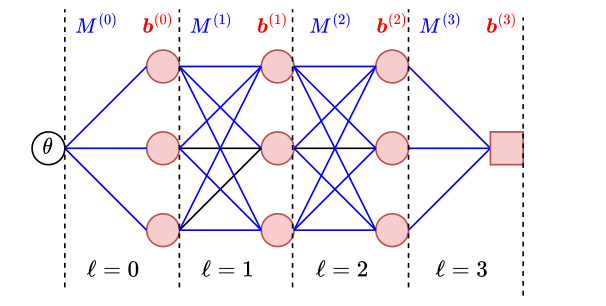

We will implement this exact network in Pytorch in the ensuing cells. 


A neural network class in `Pytorch` has to have two methods:

1. `__init__()`: This method just defines any attributes that are common to every instance of the class or anything that makes a neural network a neural network. Here that is an input dimension, output dimension, depth, width, and module dictionary. The module dictionary holds all modules (layers and activation functions) that I will use to build my network with labels that I can call later on. 

2. `forward()`: The forward method simply tells us how to progress through the network. It takes all the layers and activation functions in the module dictionary and organizes them in the desired order. 

In [5]:
class ReLUNetwork(torch.nn.Module):
    """
    Parameters
    ----------
    input_dim: int, input dimension of target function
    output_dim: int, output dimension of target function
    depth: int, number of hidden layers
    width: list of int of length = depth, defines width of each hidden layer
    """
    def __init__(self, input_dim, output_dim, depth, width):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth 
        
        self.layer_dict = torch.nn.ModuleDict()
        for i in range(self.depth+1):
            if i == 0:
                self.layer_dict['layer'+str(i)] = torch.nn.Linear(self.input_dim, self.width[i])
                self.layer_dict['act'+str(i)] = torch.nn.ReLU()
            elif i == self.depth:
                self.layer_dict['layer'+str(i)] = torch.nn.Linear(self.width[i-1], self.output_dim)
            else:
                self.layer_dict['layer'+str(i)] = torch.nn.Linear(self.width[i-1], self.width[i])
                self.layer_dict['act'+str(i)] = torch.nn.ReLU()
        
    def forward(self,x):
        for i in range(self.depth):
            x = self.layer_dict['layer'+str(i)](x)
            x = self.layer_dict['act'+str(i)](x)
        
        x = self.layer_dict['layer'+str(self.depth)](x)
        return x
            

The use of `torch.nn.ModuleDict()` to pre-organize and label all network modules is not required, but is my preferred workflow. This allows you to provide a custom name for each layer and activation function that can be referenced later on after training. I find this very useful as an experimenter and allows me to create networks in accordance with the notation I would use when writing them down on paper.  

We now leverage `ReLUNetwork` to instantiate the network pictured above with 3 hidden layers all of width 3.

In [6]:
example_net = ReLUNetwork(input_dim = 1, output_dim = 1, depth = 3, width = [3,3,3])  #create the network pictured above

print(f'Model Summary : {example_net}')  # print out summary of the created model

print(f'M1 = {example_net.layer_dict["layer1"].weight}') # print out weight matrix which transitions betweenn layer1 and layer 2

print(f'b1 = {example_net.layer_dict["layer1"].bias}') # print out bias associated with layer1

Model Summary : ReLUNetwork(
  (layer_dict): ModuleDict(
    (layer0): Linear(in_features=1, out_features=3, bias=True)
    (act0): ReLU()
    (layer1): Linear(in_features=3, out_features=3, bias=True)
    (act1): ReLU()
    (layer2): Linear(in_features=3, out_features=3, bias=True)
    (act2): ReLU()
    (layer3): Linear(in_features=3, out_features=1, bias=True)
  )
)
M1 = Parameter containing:
tensor([[-0.3332,  0.3020,  0.2361],
        [-0.3092, -0.1770,  0.0672],
        [ 0.5423,  0.5025,  0.0054]], requires_grad=True)
b1 = Parameter containing:
tensor([ 0.5486, -0.0666, -0.2776], requires_grad=True)


## 4. Training and evaluating a Pytorch model 

Training a neural network involves optimizing a chosen loss function on the training data set. From a computational perspective there are four key components. 

1. <b>Training data:</b> this will be a `DataLoader` object that holds, shuffles, and batches our training data for us.
2. <b>Model:</b> this is the pytorch network object you have created and want to train; e.g. `example_network` from above.
3. <b> Loss Function</b>: this is your optimization objective. There are many different loss functions that you could choose. For regression a common choice is the mean squared error on the traininng set which is implemented in Pytorch by `torch.nn.MSELoss()`. You can also write your own custom loss functions. Reference the Pytorch documentation to see how to do this.  
4. <b> Optimizer:</b> You need to decide how you actually want to solve the optimization problem. Most neural network training algorithms are based on stochastic gradient descent, such as the ADAM optimizer which we use here. This is implemented by Pytorch using `torch.optim.Adam()`. 


In the following cell we implement the funcntion `train_loop()` that conducts one epoch of neural network training.

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    
    Parameters
    ----------
    dataloader : Pytorch dataloader
    model : Pytorch network to be trained
    loss_fn : Pytorch loss function
    optimizer : Pytorch optimizer object

    Returns
    -------
    scalar, new loss after training epoch

    """
    
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):   
        
        # Compute prediction and loss
        pred = model(X).float()  #prediction on batch of training inputs
        pred = pred.squeeze(-1)  #removes -1 axis if it has dimension 1. Necessary before passing to loss()
        loss = loss_fn(pred, y)  #compute loss on training_batch

        # Backpropagation
        optimizer.zero_grad() # clears stored gradient information from previous step
        loss.backward()       # computes gradient of loss function wrt trainable parameters
        optimizer.step()      # optimizer takes step based on computed gradient
      
    return loss.item()



Now that we have our training loop we write a function that fully trains a network. We call this function `conduct_network_training`



In [8]:
def conduct_network_training(model, training_data, validation_data, training_parameters, save_model):
    """

    Parameters
    ----------
    model : Pytorch network object
    train_data : numpy array, training inputs and outputs format [x1, y1] (x1 can be vector valued)
    validation_data : numpy array, training inputs and outputs format [x1, y1] (x1 can be vector valued)
    test_data : numpy array, training inputs and outputs format [x1, y1] (x1 can be vector valued)
    training_parameters : dictionary, network training parameters 
                            {'batch_size': scalar,
                             'lr': scalar, learnin rate,
                             'l2_reg': scalar, L2 regularization constant,
                             'max_epochs': scalar,
                             'seed': int, random seed used by Pytorch}
    save_model : boolean, if True then model.state_dict is saved to the current working directory
    
    Returns
    -------
    plots training and validation errors as a function of epoch number
    saves the model state dictionary to the current working directory if save_model = True

    """
    
    batch_size = training_parameters['batch_size']
    
    train_data = DataLoader(TrainData(source_file = None, array = training_data), batch_size=batch_size)
    
    x_val = validation_data[:,:-1]
    y_val = validation_data[:,-1:]
    x_val_torch = torch.from_numpy(x_val).float()
    y_val_torch = torch.from_numpy(y_val).float()
    
    # Define training parameters
    
    learning_rate = training_parameters['lr']
    reg_weight = training_parameters['l2_reg']
    epochs = training_parameters['max_epochs']
   
    
    loss_fn = torch.nn.MSELoss()
    val_loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_weight)

    train_errs = []  # used to collect training error after each epoch
    val_errs = []    # used to collect validation error after each epoch
    
    # Conduct training
    
    torch.manual_seed(training_parameters['seed'])
    
    for i in tqdm(range(epochs)):
       
        loss = train_loop(train_data, model, loss_fn, optimizer) 
        train_errs.append(loss)
        

        with torch.no_grad():
            pred = model(x_val_torch)
            val_loss = val_loss_fn(pred,y_val_torch)
            
                
        val_errs.append(val_loss.item())
            
    
        
    plt.loglog(np.arange(len(train_errs)), train_errs, label = 'train errors')
    plt.loglog(np.arange(len(val_errs)), val_errs, label = 'val errors')
    plt.legend()
    plt.xlabel('number of epochs')
    plt.ylabel('MSE')
    plt.show()
    plt.close()
    
 
    
    if save_model:
        torch.save(model.state_dict())   # this uses pickle to save the model state dictionary for later network evaluation
                                           
    return None


In the next cell we implement a function `eval_network()`, which evaluates the model on prescribed test data, calculates the mean squared error, and plots the network prediction together with the true test data. Furthermore, it does this in the original domain and range of the function. Recall that the network is trainined on data scaled to $[0,1]$. The final prediction needs to be scaled back to the native domain and range. 

In [9]:
def mse(actual, pred): 
    """
    Parameters
    ----------
    actual : numpy array, true value
    pred : numpy array, predicted value

    Returns
    -------
    scalar mean squared error in pred approximation of actual

    """
    
    return np.square(np.subtract(np.array(actual),np.array(pred))).mean() 


def eval_network(model, test_data, input_scaler, output_scaler):
    """
    Parameters
    ----------
    model : Pytorch model which has been training
    test_data : numpy array, test_data
    input_scaler : scaler object associated with test inputs
    output_scaler : scaler object associated with test outputs
    
    Returns
    -------
    prints MSE on test
    plots network prediction vs truth
    
    """
    # put network in evaluation mode
    model.eval()
    
    x_test = test_data[:,:-1]  #test inputs
    y_test = test_data[:,-1:]  #test outputs

    x_test_torch = torch.from_numpy(x_test).float()  #convert inputs to torch tensor
    test_pred_torch = model(x_test_torch)            #compute network predictionn
    test_pred = test_pred_torch.detach().numpy()     #convert network prediction back to numpy array

    # return test inputs, outputs, and network prediction back to orginial domain and range
    inverse_scaled_x_test = input_scaler.inverse_transform(x_test)
    inverse_scaled_y_test = output_scaler.inverse_transform(y_test)
    inverse_scaled_test_pred =  output_scaler.inverse_transform(test_pred)
    
    # plot results
    plt.plot(inverse_scaled_x_test, inverse_scaled_y_test, color = 'k', label = 'truth')
    plt.plot(inverse_scaled_x_test, inverse_scaled_test_pred, color = 'r', linestyle = '--', label = 'network prediction')
    plt.legend()
    plt.xlabel('x')
    plt.show()
    plt.close()
    
    #compute and print out error
    error = mse(inverse_scaled_y_test, inverse_scaled_test_pred)
    print(f'Mean Squared Error: {error}')
    
    return None



Given all the functions above, the process of creating, training, and evaluating a network can be done compactly in just a few lines of code. The full workflow in the following cell proceeds as follows:

1. Create neural network
2. Choose hyper-parameters and organize them into a training prameter dictionary
3. Train the network
4. Evaluate the network on the test data

100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.98it/s]


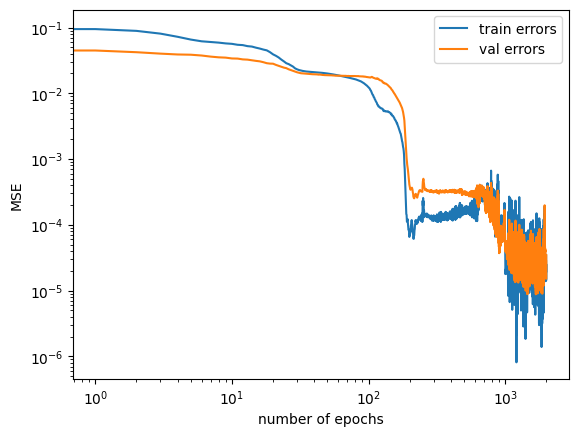

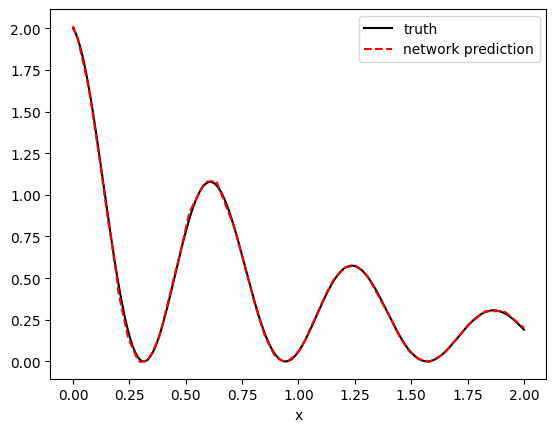

Mean Squared Error: 0.00012055263311021785


In [15]:
relu_net = ReLUNetwork(1,1,4,[20,20,20,20])

train_params = {'batch_size' : 8,
                'lr' : 1e-3,
                'l2_reg' : 1e-8,
                'max_epochs' : 2000,
                'seed' : 101}

conduct_network_training(model = relu_net, 
                         training_data = train_data,
                         validation_data = val_data,
                         training_parameters = train_params,
                         save_model = False)

eval_network(model = relu_net, 
             test_data = test_data,
             input_scaler = input_scaler,
             output_scaler = output_scaler)


## 5. Comments on hyper-parameter tuning

Stochastic gradient descent based training algorithms generally have several hyperparameters that are consequential in network training. Optimally choosing these hyperparamters prior to training or tuning them efficiently is an active area of research and there is no general consensus about how to do this effectively. For better or for worse, in the absence of an infinite computational budget, hyperparameter tuning is a bit heuristic and experience based at this point. Here are some ad hoc guidelines:


1. Learning rate: This should be adaptive. One common strategy I use is to reduce the learning rate when a plateau in the training loss is detected. There are several built-in Pytorch learning rate schedulers that are contained in `torch.optim.lr_sceduler`. I recommend you read up on them in the Pytorch documentation and pick one that works well for your problem.  

2. Number of training epochs: This should be adaptive. The loss during network training is rarely monotonic. It is stochastic and tends to jump around. Especially as the error becomes saturated we often see rapid oscillation in the training loss. You can monitor loss behavior and stop training accordingly. Common metrics include monitoring for sustained increase in training loss, a sustained divergence of training and validation loss, or plateau in training loss.

3. Chooosing your network architercture (width and depth) a-priori before training is not well understood. Intuitively, number of training data and number of trainable parameters (controlled by width and depth) should probably be proportional. This is the case for other standard regression and function approximation methods after all; e.g., least squares. 

4. Regularization: There are many different kinds; Tikhonov (L2), L1, MC dropout to name a few. They accomplish different goals. For example, L2 regularization is often used to prevent overfitting whereas L1 regularization is used for feature detection. Generally I find more regularization is required when training data is sparse. Both the type and degree of regularization are generally problem dependent.

5. Batch size. If your batch size is your entire data set, then any stochastic gradient descent based training algorithm is no longer stochastic. Aside from that, batch size generally depends at least weakly on the learning rate. If batch size is chosen very large then training speeds up, but its easy to overshoot desired minima on the loss landscape. Hence if you have a large batch size a small learning rate is usually used and vice-versa. 


If your computational budget allows for validation data, I suggest doing a hyperparameter grid search. This can be computationally expensive if your neural network is large, but is generally necessary especially if you are working with sparser training data. You can implement a grid-search yourself or use a library routine.  I find scikitlearn's `ParamemterGrid` to be an efficient tool for grid search implementation. 